In [68]:
import torch
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.core.display import display, HTML
from bertviz import head_view, model_view

from evaluate_explanations import evaluate_word_level, evaluate_sentence_level
from utils import aggregate_pieces, read_qe_files
from model.xlm_roberta import load_checkpoint
from explain_attn import get_valid_explanations

In [69]:
def detokenize(pieces):
    return ''.join(pieces).replace('▁', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(0, 255, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(255, 0, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array / color_array.abs().max()):
        if color > 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="100%">{}</div>'.format(colored_string)
    display(HTML(html_text))

def plot_attention_map(words, attn_weights, vmax=1, ax=None):
    df = pd.DataFrame(attn_weights.numpy(), columns=words, index=words)
    sns.heatmap(df, vmax=vmax, cmap="Greens", square=True, cbar=False, ax=ax)

In [70]:
device = torch.device("cpu")

# 1) Load Checkpoint
checkpoint = 'experiments/lightning/version_02-08-2021--23-36-52/epoch=4-step=30624.ckpt'
model = load_checkpoint(checkpoint, output_norm=False, norm_strategy='weighted_norm')
model.eval()
model.zero_grad()
model.to(device)

# 2) Prepare TESTSET
data = read_qe_files('data/ro-en/dev')
e_mt_gold = [sample["tgt_tags"] for sample in data]
e_src_gold = [sample["src_tags"] for sample in data]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing SparseXLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing SparseXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SparseXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Adding Adaptors.


In [181]:
idx = 10
layer_id = 18
head_id = 3
reduction = 'sum'

sample = data[idx]
mt_word_tags = torch.tensor(e_mt_gold[idx])
src_word_tags = torch.tensor(e_src_gold[idx])

with torch.no_grad():
    batch, targets = model.prepare_sample([sample], cuda=False)
    pred_score, attn = model.forward(**batch, return_attentions=True)
    pred_score = pred_score.view(-1).detach().cpu().item()
    attn = torch.stack(attn).detach().cpu()
    input_ids = batch['input_ids']
    attn_mask = batch['attention_mask']
    fs_mask = batch['first_sentence_mask']
    eos_idx = fs_mask.squeeze().sum()
    fp_mask = batch['first_piece_mask']
    gold_score = targets['score'].squeeze().item()
    tokens = model.tokenizer.tokenizer.convert_ids_to_tokens(input_ids.squeeze())
    seq_len = attn.shape[-1]

mt_attn = attn[:, :, :, :eos_idx, :eos_idx]
src_attn = attn[:, :, :, eos_idx:, eos_idx:]
mt_tokens = tokens[:eos_idx]
src_tokens = tokens[eos_idx:]

attn_sum = (attn[layer_id, 0, head_id] * attn_mask.unsqueeze(-1).float()).sum(1)
attn_avg = attn_sum / attn_mask.sum(-1).unsqueeze(-1).float()
explanations = get_valid_explanations(attn_avg, attn_mask, fs_mask, fp_mask)
e_mt, e_src, e_mt_fp_mask, e_src_fp_mask = explanations[0]
e_mt = torch.from_numpy(e_mt)
e_src = torch.from_numpy(e_src)
e_mt_fp_mask = torch.from_numpy(e_mt_fp_mask)
e_src_fp_mask = torch.from_numpy(e_src_fp_mask)

ag_e_mt = aggregate_pieces(e_mt, e_mt_fp_mask, reduction=reduction)
ag_e_src = aggregate_pieces(e_src, e_src_fp_mask, reduction=reduction)

In [182]:
print('pred score:', pred_score)
print('gold score:', gold_score)
print('')
print('pred:')
# colorize_twoway(mt_tokens, e_mt)
colorize_twoway(detokenize(mt_tokens).split(), ag_e_mt)
print('gold:') 
colorize_twoway(detokenize(mt_tokens).split(), torch.tensor([0] + mt_word_tags.tolist() + [0]))
print('')
print('pred:')
# colorize_twoway(src_tokens, e_src)
colorize_twoway(detokenize(src_tokens).split(), ag_e_src)
print('gold:') 
colorize_twoway(detokenize(src_tokens).split(), torch.tensor([0] + src_word_tags.tolist() + [0]))

pred score: 26.296628952026367
gold score: 25.16666603088379

pred:


gold:



pred:


gold:


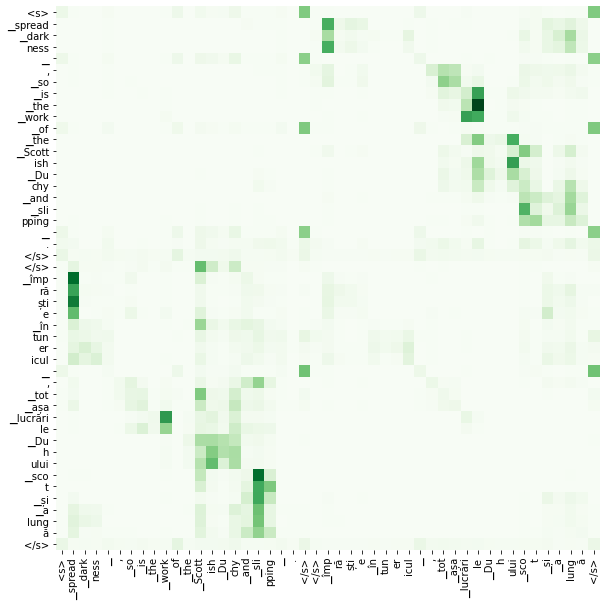

In [184]:
plt.figure(figsize=(10,10))
plot_attention_map(tokens, attn[18,0,0], vmax=None)

In [165]:
# not very useful afterall
# head_view(src_attn, src_tokens)